In [1]:
## follow the tutorial on https://github.com/boxiangliu/enformer

import tensorflow as tf
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2023-02-27 14:55:34.223709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 14:55:37.530910: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.0/extras/CUPTI/lib64:/usr/local/cuda-10.0/lib64:/opt/slurm/slurm-20.11.0/lib64:/opt/slurm/pe2/slurm/centos7/lib64:/opt/slurm/slurm-20.11.0/lib64:/opt/slurm/slurm-20.11.0/lib64:
2023-02-27 14:55:37.531039: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-27 14:56:00.926607: W 

In [2]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/gpfs/commons/home/tlin/data/enformer/hg38.fa'
clinvar_vcf = '/gpfs/commons/home/tlin/data/enformer/clinvar.vcf.gz'

In [3]:
# Download targets from Basenji2 dataset 
# Cite: Kelley et al Cross-species regulatory sequence activity prediction. PLoS Comput. Biol. 16, e1008050 (2020).
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets.head(3)

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion


In [4]:
pyfaidx.Faidx(fasta_file)

Faidx("/gpfs/commons/home/tlin/data/enformer/hg38.fa")

In [4]:
# @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)


class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism
  
  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.
    
  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features
    
  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]


# TODO(avsec): Add feature description: Either PCX, or full names.

# @title `variant_centered_sequences`

class FastaStringExtractor:
    
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def variant_generator(vcf_file, gzipped=False):
  """Yields a kipoiseq.dataclasses.Variant for each row in VCF file."""
  def _open(file):
    return gzip.open(vcf_file, 'rt') if gzipped else open(vcf_file)
    
  with _open(vcf_file) as f:
    for line in f:
      if line.startswith('#'):
        continue
      chrom, pos, id, ref, alt_list = line.split('\t')[:5]
      # Split ALT alleles and return individual variants as output.
      for alt in alt_list.split(','):
        yield kipoiseq.dataclasses.Variant(chrom=chrom, pos=pos,
                                           ref=ref, alt=alt, id=id)


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
  seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

  for variant in variant_generator(vcf_file, gzipped=gzipped):
    interval = Interval(chr_prefix + variant.chrom,
                        variant.pos, variant.pos)
    interval = interval.resize(sequence_length)
    center = interval.center() - interval.start

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    yield {'inputs': {'ref': one_hot_encode(reference),
                      'alt': one_hot_encode(alternate)},
           'metadata': {'chrom': chr_prefix + variant.chrom,
                        'pos': variant.pos,
                        'id': variant.id,
                        'ref': variant.ref,
                        'alt': variant.alt}}
    
    
def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

## Make predictions for a genetic sequence

In [7]:
model = Enformer(model_path)
fasta_extractor = FastaStringExtractor("/gpfs/commons/home/tlin/data/enformer/hg38.fa")
fasta_file = "/gpfs/commons/home/tlin/data/enformer/hg38.fa"

2023-02-27 14:57:52.021859: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.0/extras/CUPTI/lib64:/usr/local/cuda-10.0/lib64:/opt/slurm/slurm-20.11.0/lib64:/opt/slurm/pe2/slurm/centos7/lib64:/opt/slurm/slurm-20.11.0/lib64:/opt/slurm/slurm-20.11.0/lib64:
2023-02-27 14:57:52.021964: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-27 14:57:52.021995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pe2cc3-043.c.nygenome.org): /proc/driver/nvidia/version does not exist
2023-02-27 14:57:52.022353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following

In [32]:
# @title Make predictions for an genomic example interval
## use a gene as example 
## BIN1 chr2:127,048,027-127,107,288
target_interval = kipoiseq.Interval('chr2', 127_048_027, 127_107_288)  # @param
sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

In [93]:
## make this a function
model = Enformer(model_path)
SEQUENCE_LENGTH = 393216
def prediction (chr_num, start, end):
    #chr_num, start, end = str(chr_num), str(start), str(end)
    if("," in start):
        start = start.replace(",","_")
        end = end.replace(",","_")
        SEQUENCE_LENGTH = int(end.replace("_","")) - int(start.replace("_",""))
    else:
        SEQUENCE_LENGTH = int(end.replace(",","")) - int(start.replace(",",""))
    SEQUENCE_LENGTH = 393216
    target_interval = kipoiseq.Interval(chr_num, int(start), int(end))
    sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
    predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]
    
    tracks = {'CAGE: Brain, adult':  np.log10(1 + predictions[:, 4680]),
          'CAGE:Dendritic Cells - monocyte immature derived': np.log10(1 + predictions[:, 4761]),
          'CAGE:B lymphoblastoid cell line': np.log10(1 + predictions[:, 5110]),
          'CAGE:Astrocyte - cerebellum': np.log10(1 + predictions[:, 4873]),
          'CAGE:skin, adult': np.log10(1 + predictions[:, 4970])}

    
    print(SEQUENCE_LENGTH)
    plot_tracks(tracks, target_interval)
    return(predictions)

393216


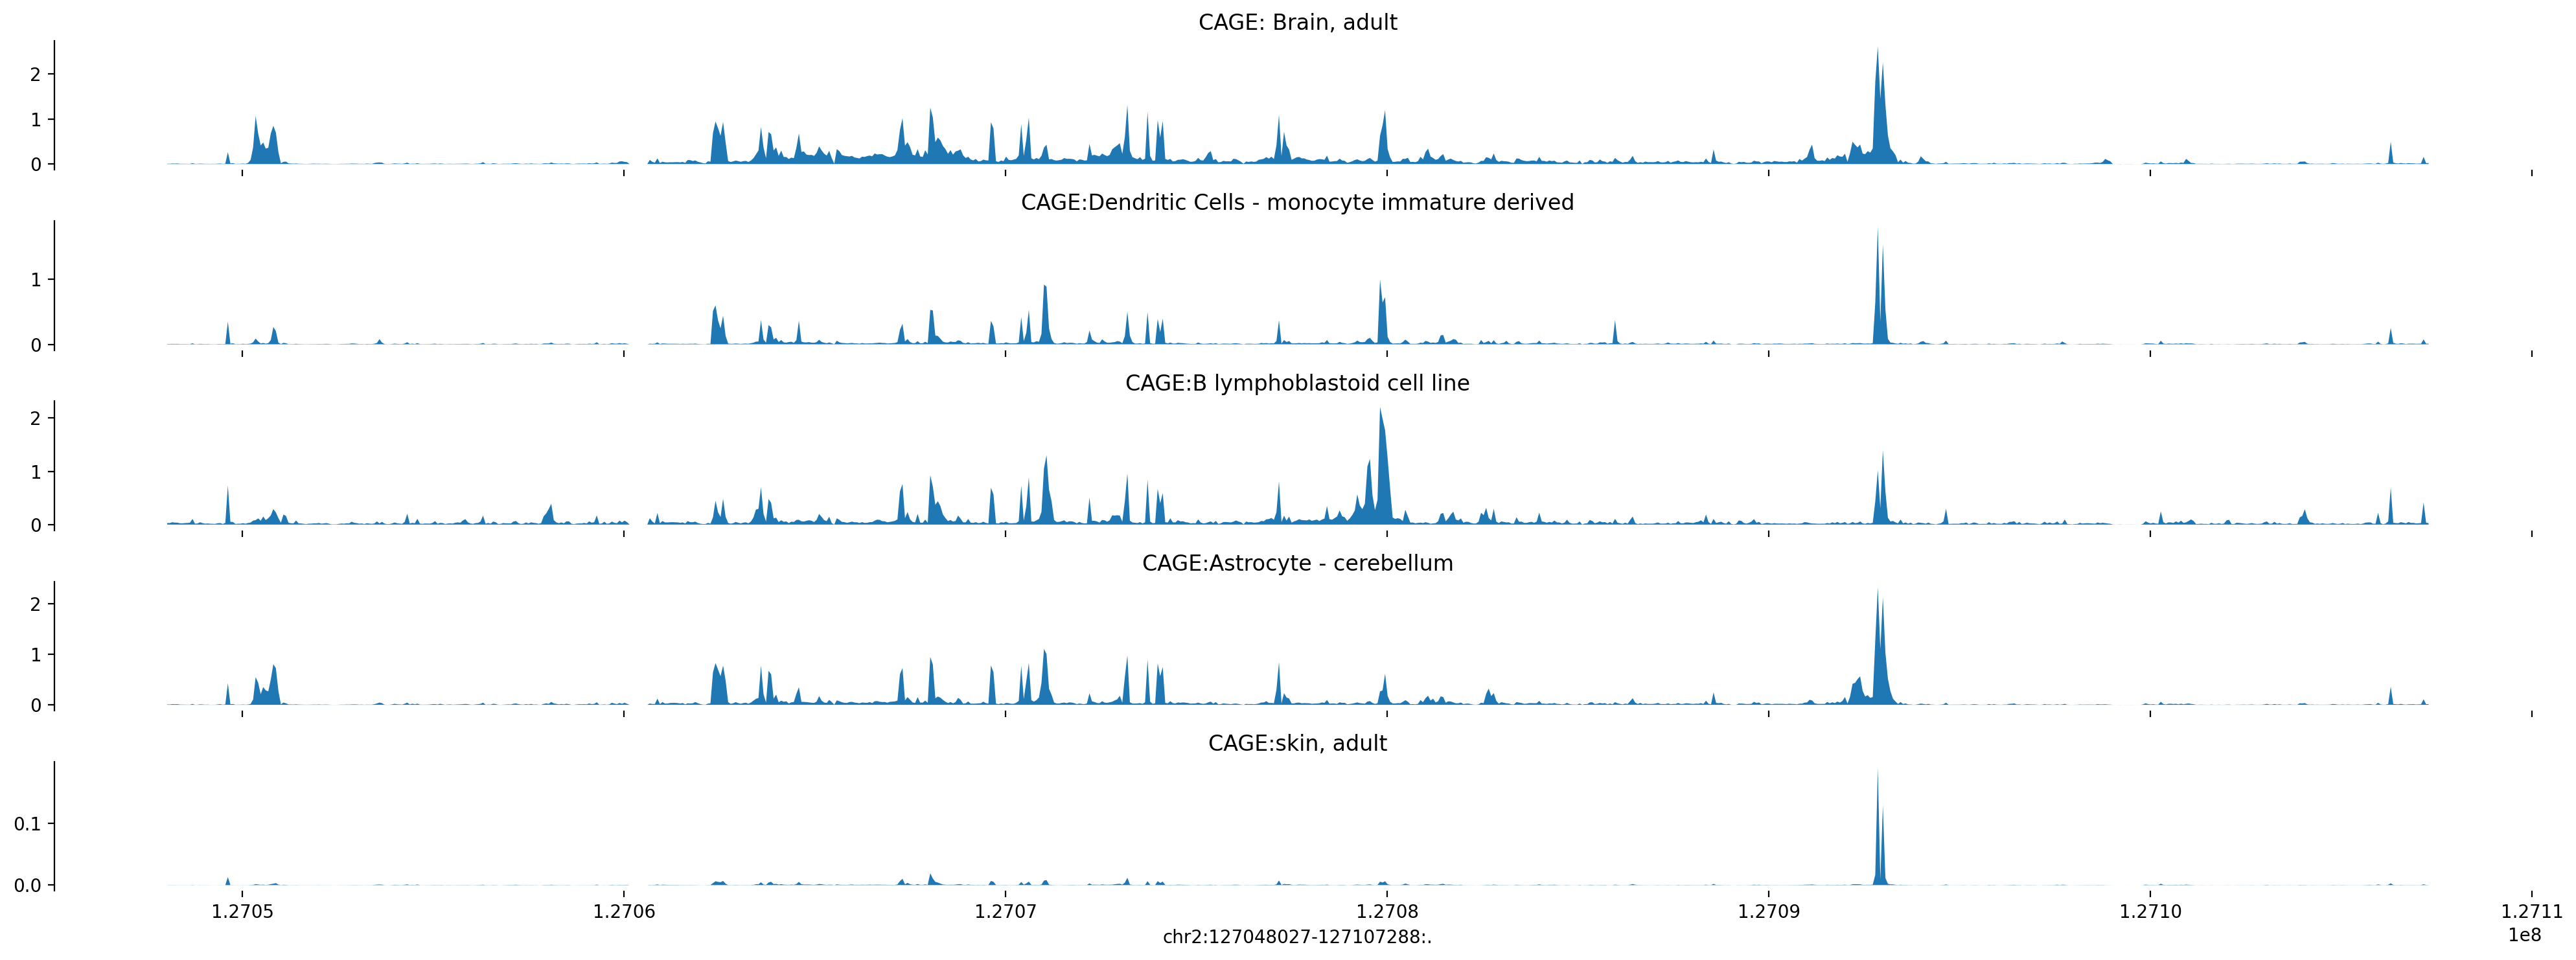

In [94]:
test = prediction('chr2', '127_048_027', '127_107_288')

In [22]:
pd.set_option('display.max_colwidth', -1)
df_targets.iloc[5110].description

/gpfs/commons/home/tlin/miniconda3/envs/enformer/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


'CAGE:B lymphoblastoid cell line: GM12878 ENCODE, biol_'

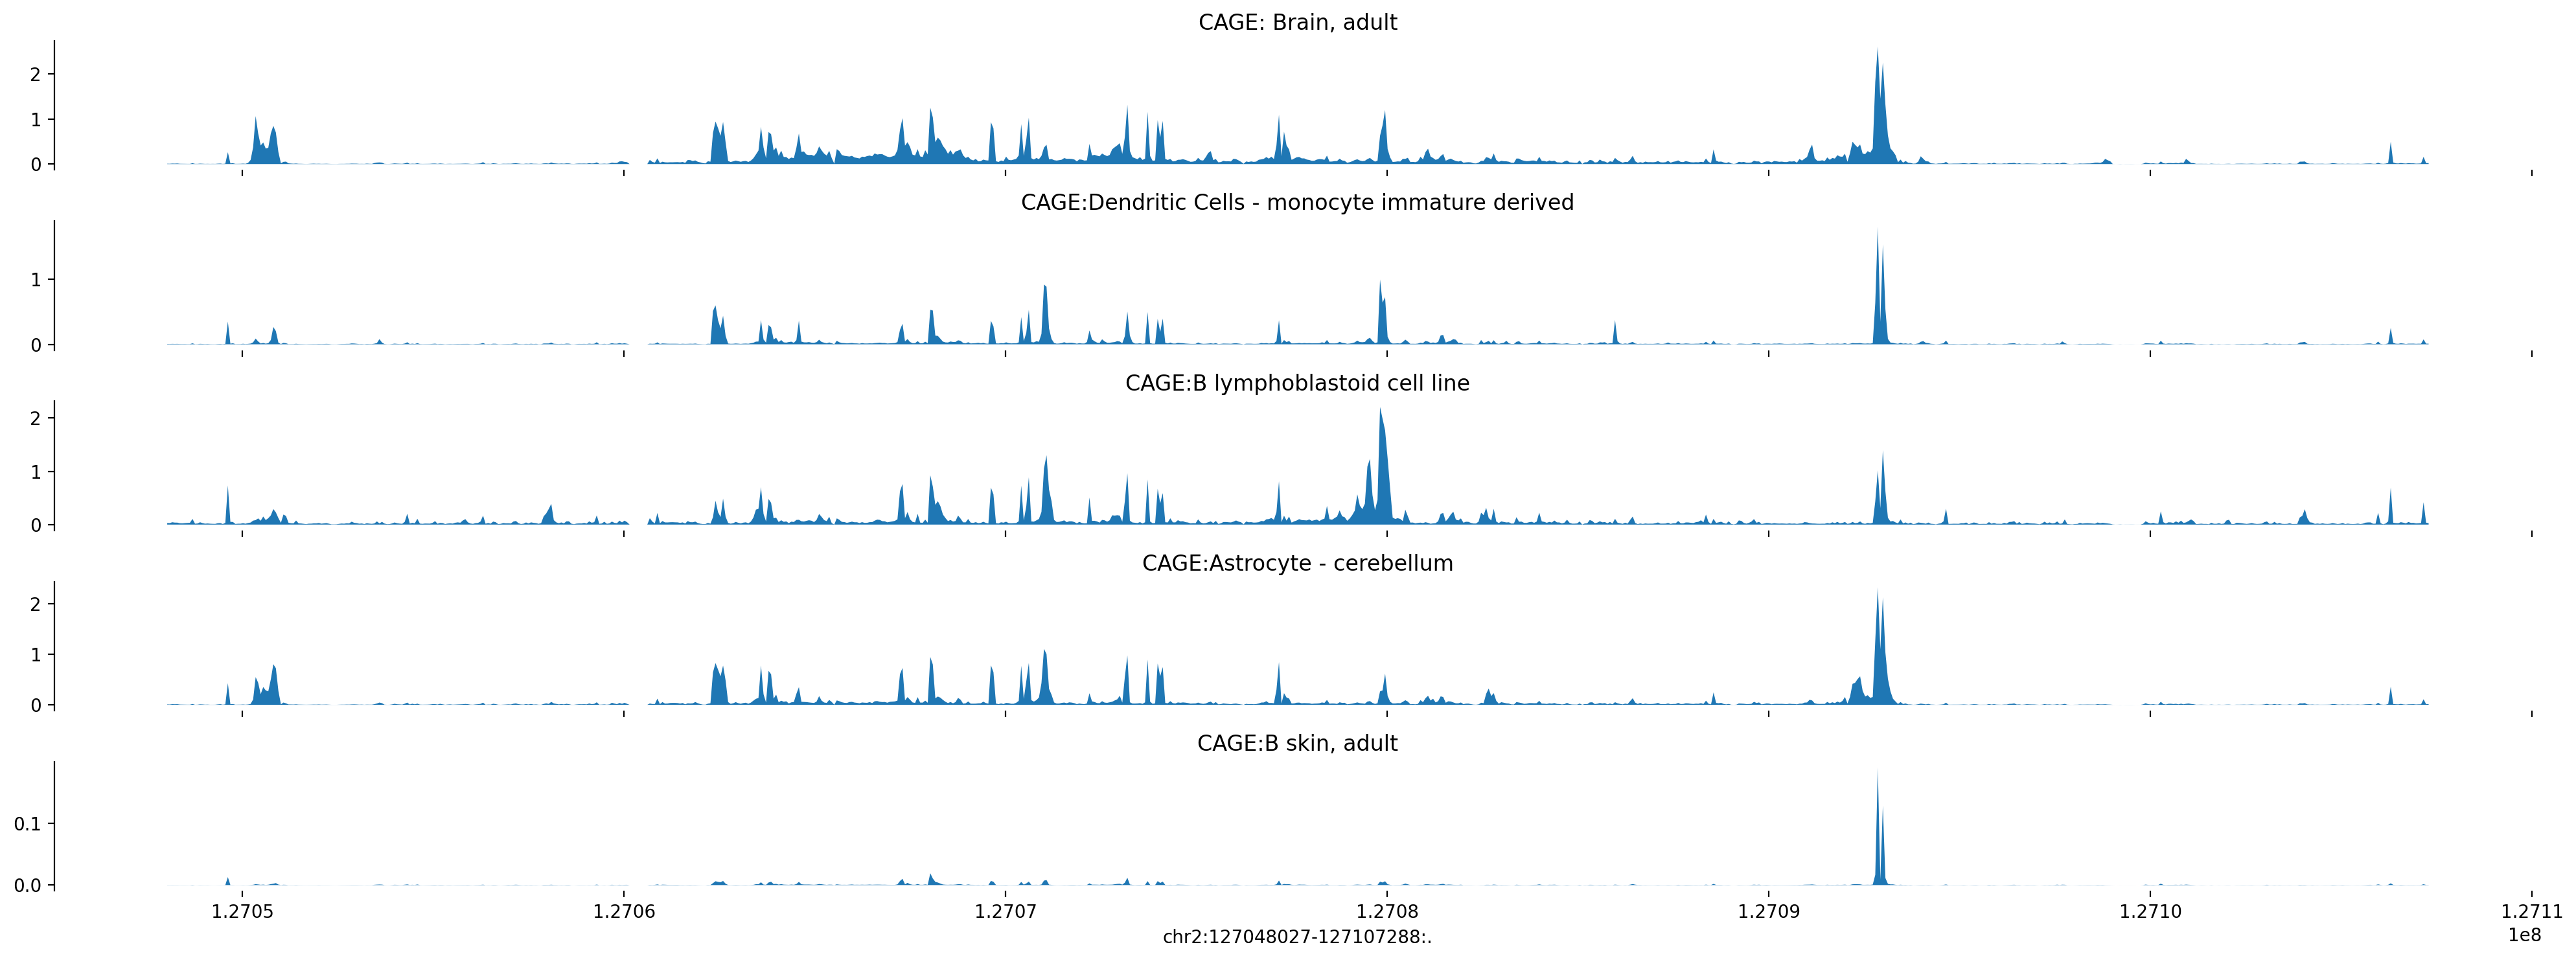

In [33]:
# @title Plot tracks
## compare ad-related and ad-nonrelated cell
tracks = {'CAGE: Brain, adult':  np.log10(1 + predictions[:, 4680]),
          'CAGE:Dendritic Cells - monocyte immature derived': np.log10(1 + predictions[:, 4761]),
          'CAGE:B lymphoblastoid cell line': np.log10(1 + predictions[:, 5110]),
          'CAGE:Astrocyte - cerebellum': np.log10(1 + predictions[:, 4873]),
          'CAGE:skin, adult': np.log10(1 + predictions[:, 4970])}
plot_tracks(tracks, target_interval)

In [ ]:
## Variant scoring

In [36]:
# @title Score the variant

variant = kipoiseq.Variant('chr2', 127077657, 'C', 'T', id='rs4663105')  # @param

# Center the interval at the variant
interval = kipoiseq.Interval(variant.chrom, variant.start, variant.start).resize(SEQUENCE_LENGTH)
seq_extractor = kipoiseq.extractors.VariantSeqExtractor(reference_sequence=fasta_extractor)
center = interval.center() - interval.start

reference = seq_extractor.extract(interval, [], anchor=center)
alternate = seq_extractor.extract(interval, [variant], anchor=center)

# Make predictions for the refernece and alternate allele
reference_prediction = model.predict_on_batch(one_hot_encode(reference)[np.newaxis])['human'][0]
alternate_prediction = model.predict_on_batch(one_hot_encode(alternate)[np.newaxis])['human'][0]

In [34]:
(127048027+127107288)/2


127077657.5

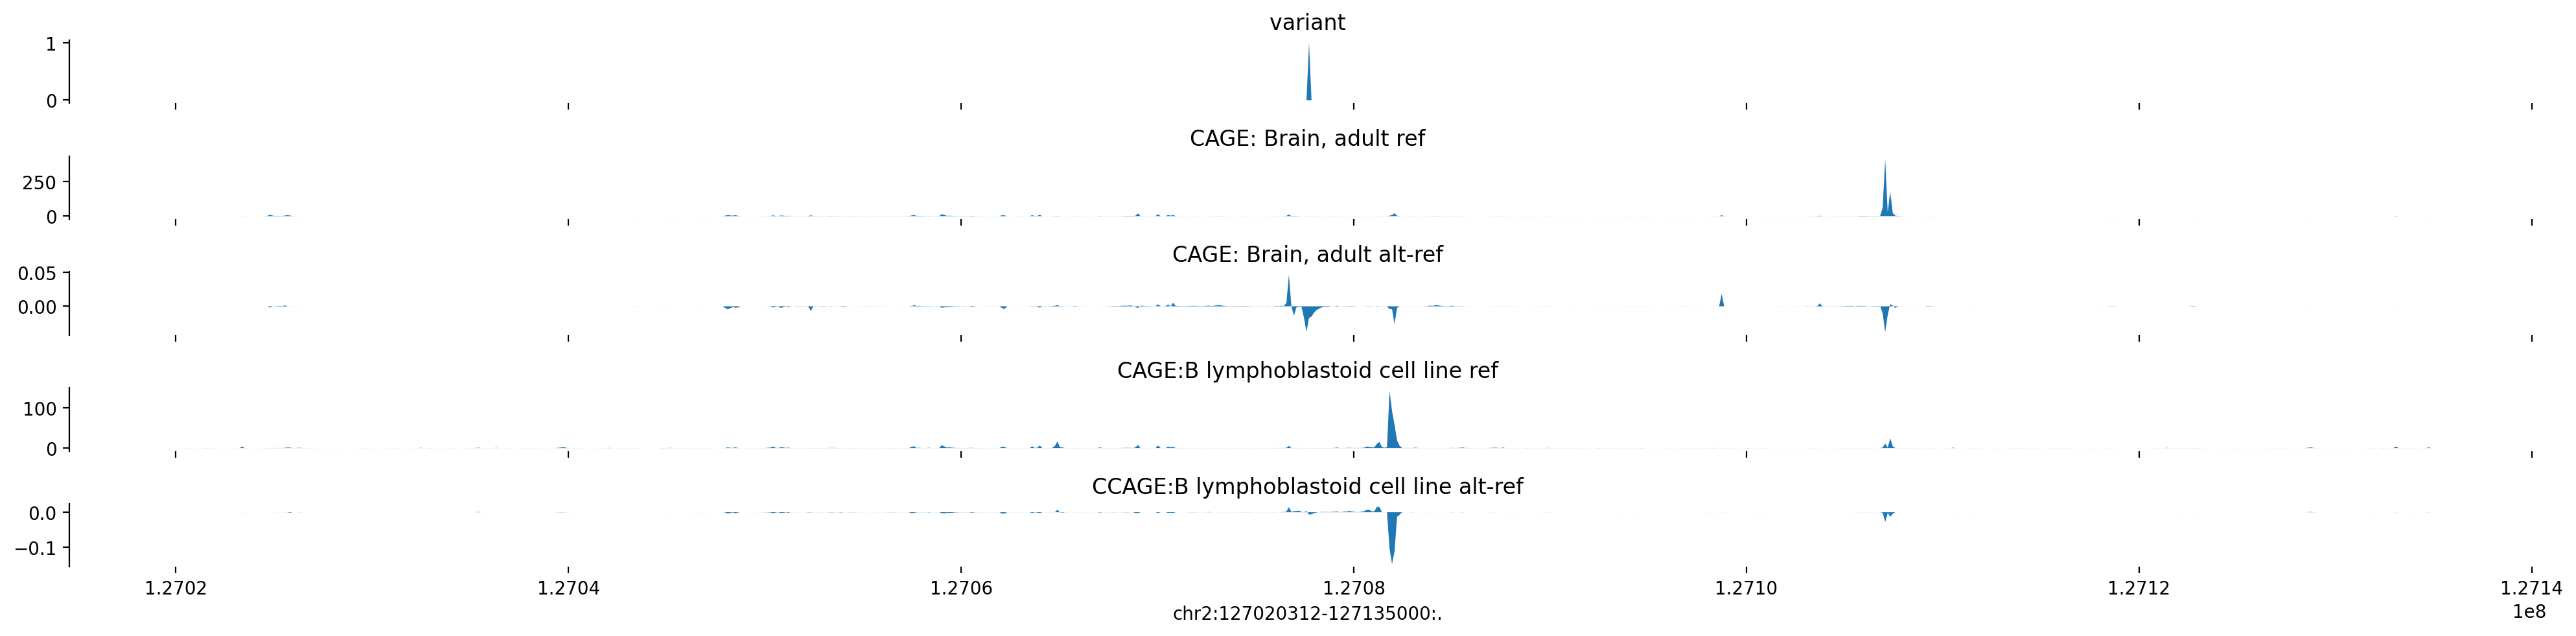

In [37]:
# @title Visualize some tracks
variant_track = np.zeros_like(reference_prediction[:, 0], dtype=bool)
variant_track[variant_track.shape[0] // 2] = True
tracks = {'variant': variant_track,
          'CAGE: Brain, adult ref': reference_prediction[:, 4680],
          'CAGE: Brain, adult alt-ref': alternate_prediction[:, 4680] - reference_prediction[:, 4680],
          'CAGE:B lymphoblastoid cell line ref': reference_prediction[:, 5110],
          'CCAGE:B lymphoblastoid cell line alt-ref': alternate_prediction[:, 5110] - reference_prediction[:, 5110],
          }

plot_tracks(tracks, interval.resize(reference_prediction.shape[0] * 128), height=1)

## score variants in VCF 

In [8]:
## report top 20 pcs
enformer_score_variants = EnformerScoreVariantsPCANormalized(model_path, transform_path, num_top_features=20)

2023-02-27 15:15:06.777640: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".
/gpfs/commons/home/tlin/miniconda3/envs/enformer/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/gpfs/commons/home/tlin/miniconda3/envs/enformer/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning:

In [10]:
SEQUENCE_LENGTH

393216

In [9]:
# Score the first 5 variants from ClinVar
# Lower-dimensional scores (20 PCs)
it = variant_centered_sequences(clinvar_vcf, sequence_length=SEQUENCE_LENGTH,
                                gzipped=True, chr_prefix='chr')
example_list = []
for i, example in enumerate(it):
  if i >= 5:
    break
  variant_scores = enformer_score_variants.predict_on_batch(
      {k: v[tf.newaxis] for k,v in example['inputs'].items()})[0]
  variant_scores = {f'PC{i}': score for i, score in enumerate(variant_scores)}
  example_list.append({**example['metadata'],
                       **variant_scores})
  if i % 2 == 0:
    print(f'Done {i}')
df = pd.DataFrame(example_list)
df

Done 0
Done 2
Done 4


,chrom,pos,id,ref,alt,PC0,PC1,PC2,PC3,PC4,...,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,chr1,69134,2205837,A,G,-7.431274,2.266990,-4.216589,7.758461,1.582231,...,1.202235,-0.871122,-5.367293,1.530326,-1.950786,4.245638,2.409186,-0.615991,-1.739802,0.807660
1,chr1,69581,2252161,C,G,-2.233064,4.261085,-6.350357,2.497619,-2.610562,...,-1.176706,1.512291,-2.997771,0.622836,-0.048775,1.530418,0.660925,-0.001716,-2.143412,0.974279
2,chr1,69682,2396347,G,A,-8.017596,4.184952,-6.304121,6.835007,-0.563062,...,0.037704,1.210621,-9.287115,2.817412,-1.254947,5.417459,1.267160,-1.760550,-3.680316,0.831270
3,chr1,69769,2288999,T,C,-5.981140,1.303140,-2.802904,2.191438,-0.429882,...,0.604286,-0.166526,-1.652822,0.070502,0.325371,2.219601,1.764310,-1.869962,-2.680429,0.910439
4,chr1,69995,2351346,G,C,-2.018058,0.913087,-1.718803,1.567120,-0.250704,...,0.330510,0.086407,-0.864384,0.322681,-0.600698,0.948648,0.182838,0.494817,0.371568,-0.111416


In [11]:
df

,chrom,pos,id,ref,alt,PC0,PC1,PC2,PC3,PC4,...,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,chr1,69134,2205837,A,G,-7.431274,2.266990,-4.216589,7.758461,1.582231,...,1.202235,-0.871122,-5.367293,1.530326,-1.950786,4.245638,2.409186,-0.615991,-1.739802,0.807660
1,chr1,69581,2252161,C,G,-2.233064,4.261085,-6.350357,2.497619,-2.610562,...,-1.176706,1.512291,-2.997771,0.622836,-0.048775,1.530418,0.660925,-0.001716,-2.143412,0.974279
2,chr1,69682,2396347,G,A,-8.017596,4.184952,-6.304121,6.835007,-0.563062,...,0.037704,1.210621,-9.287115,2.817412,-1.254947,5.417459,1.267160,-1.760550,-3.680316,0.831270
3,chr1,69769,2288999,T,C,-5.981140,1.303140,-2.802904,2.191438,-0.429882,...,0.604286,-0.166526,-1.652822,0.070502,0.325371,2.219601,1.764310,-1.869962,-2.680429,0.910439
4,chr1,69995,2351346,G,C,-2.018058,0.913087,-1.718803,1.567120,-0.250704,...,0.330510,0.086407,-0.864384,0.322681,-0.600698,0.948648,0.182838,0.494817,0.371568,-0.111416


In [13]:
enformer_score_variants_all = EnformerScoreVariantsNormalized(model_path, transform_path)

/gpfs/commons/home/tlin/miniconda3/envs/enformer/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/gpfs/commons/home/tlin/miniconda3/envs/enformer/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator TruncatedSVD from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/gpfs/commons/home/tlin/miniconda3/envs/enformer/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator Pipeline from versio

In [48]:
it

<generator object variant_centered_sequences at 0x7fbbc6dcaa50>

In [49]:
for i , example in enumerate(it):
    print(example)
    break

{'inputs': {'ref': array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       ...,
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]], dtype=float32), 'alt': array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       ...,
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]], dtype=float32)}, 'metadata': {'chrom': 'chr1', 'pos': 69134, 'id': '2205837', 'ref': 'A', 'alt': 'G'}}


In [41]:
enformer = Enformer.from_pretrained('EleutherAI/enformer-official-rough')